## Tumor simulation
To model the expected relationship between genomic divergence and spatial diversity, I used a cell automata model based on the one described in "Evolution and Phenotypic Selection of Cancer Stem Cells" (Poleszczuk, Hahnfeldt, Enderling, PLOS Computational Biology, 2015)

## Cancer Stem Cell vs. Clonal
Start w/ stem cell object that have a certain proliferation and mutation rate. Stem cells can divide to give rise to either another stem cell (symmetric division) or a clonal cell (asymmetric division) which has an assoicated mortality rate and limited proliferation capacity. FOr the pure clonal model, start with a cell object that does not have limited proliferation capacity but a discrete mortality rate and only symmeric divison. 


In [2]:
import itertools
import operator
import copy
import numpy as np
import pandas as pd
import math
import operator
from matplotlib import pyplot as plt
import matplotlib as mpl
import baltic as bt
from statsmodels.nonparametric.api import KernelReg
import pickle
import random


In [3]:

def calc_LBI(tree, attr = 'lb', tau=0.0005, transform = lambda x:x):
    '''.
    traverses the tree in postorder and preorder to calculate the
    up and downstream tree length exponentially weighted by distance.
    then adds them as LBI
    tree -- dendropy tree for whose node the LBI is being computed
    attr	 -- the attribute name used to store the result

    '''
    newtree=copy.deepcopy(tree)
    newtree.postorder_node = sorted(newtree.Objects, key=operator.attrgetter('height'), reverse = True)
    newtree.preorder_internal_node = sorted(newtree.nodes, key = operator.attrgetter('height'), reverse = False)

    # traverse the tree in postorder (children first) to calculate msg to parents
    for node in newtree.postorder_node:
        node.down_polarizer = 0
        node.up_polarizer = 0
        if isinstance(node,bt.node) or node.branchType=='node':
            for child in node.children:
                node.up_polarizer += child.up_polarizer
        bl =  node.length/tau
        node.up_polarizer *= np.exp(-bl)
        node.up_polarizer += tau*(1-np.exp(-bl))

    # traverse the tree in preorder (parents first) to calculate msg to children
    for node in newtree.preorder_internal_node:
        for child1 in node.children:
            child1.down_polarizer = node.down_polarizer
        for child2 in node.children:
            if child1!=child2:
                child1.down_polarizer += child2.up_polarizer

        bl =  child1.length/tau
        child1.down_polarizer *= np.exp(-bl)
        child1.down_polarizer += tau*(1-np.exp(-bl))

    # go over all nodes and calculate the LBI (can be done in any order)
    for node in newtree.postorder_node:
        tmp_LBI = node.down_polarizer
        if isinstance(node,bt.node) or node.branchType=='node':
            for child in node.children:
                tmp_LBI += child.up_polarizer
    #node.__setattr__(attr, transform(tmp_LBI))
        setattr(node, attr, transform(tmp_LBI))
    return newtree

In [4]:
import pandas as pd
def rank_LBI(tree):
    #assert hasattr(tree, 'lb'), 'tree must have LBI attribute lb'
    newtree = copy.deepcopy(tree)
    leaves_lb = []
    for k in newtree.leaves:
        if k.alive:
            leaves_lb.append(k.lb)
        #index_list.append(leaf.name)
    lb_series = pd.Series(leaves_lb)
    ranked_lb = lb_series.rank(pct = True)
    i = 0
    for k in newtree.leaves:
        if k.alive:
            setattr(k, 'rank', ranked_lb[i])
            k.rank = ranked_lb[i]
            i += 1
    return newtree


## Define cancer simulation 


In [7]:

def adjacent_cell(lattice,i,j): #function to check if adjacent cells are empty
    free_cells = []
    change = [1,-1]
    for c in change:
        checki = lattice[i+c,j]
        if checki == None:
            free_cells.append([i+c,j])
        checkj = lattice[i, j+c]
        if checkj == None:
            free_cells.append([i,j+c])
        for h in change:
            checkd = lattice[i+h,j+c]
            if checkd == None:
                free_cells.append([i+h,j+c])
    return free_cells

def cancer_sim(founder_cells = 1,deltat=(1/float(24)),CSC = True,max_cells = 1000,proliferationCSC = 1, proliferationCC = 2, motility = 15, pmax = 10, mortality = 0.1, mutation = 0.1, selection = False,ps = 0.05):    

    #create classes
    class Cell:
        def __init__(self):
            self.parent = None #cell it was derived from
            self.children = [] #set of daughter cells
            self.locx = None #x location in lattice
            self.locy = None #y location in lattice
            self.birthdate = None
            self.deathdate = None
            self.pmax = pmax #proliferation potential
            self.cellnum = None #unique cell number to identify
            self.alpha = mortality #probability of sponaneous death
            self.mutation_rate = mutation #probability of mutation per cell division
            self.motility = motility #probability of migration per day
            self.proliferation_rate = proliferationCC #average cell divisions per day
            self.clone = None
            self.mutations = []
            self.ps = 0
            self.curnode = None
            self.new_mut = False
            self.group = None
            self.alive = True


    class StemCell(Cell): #define stem cell class
        def __init__(self):
            Cell.__init__(self)
            self.pmax = float('inf') #infinite proliferation potential
            self.alpha = 0 #immortal
            self.ps = ps #probability of symmetric division
            self.proliferation_rate = proliferationCSC
            self.alive = True
    
    class Group():
        def __init__(self):
            self.alive_cells = []
            self.node = None
            self.id = None


    #create lattice array
    N = max_cells # starting demensions of lattice
    lattice = np.empty( (N,N), dtype=object)

    #parameters
    proliferation_rate_CC = proliferationCC #proliferation rate of clonal cell
    proliferation_rate_CSC = proliferationCSC #proliferation rate of cancer stem cell
    pmax_CC = pmax
    migration_potential = motility
    alpha_CC = mortality
    cur_cellnum = 0
    cur_mutnum = 0
    cur_clonenum = 1
    cur_index = 1
#     cur_group = 0
    mutation_rate = mutation
    time = 0

#     tree = bt.tree() #initiate tree object to track genetic evolution
    
#     #set up root for genetic tree
#     root = bt.node()
#     root.length=-0.01 ## branch length,
#     root.height=-0.01 ## height, set by traversing the tree, which adds up branch lengths along the way
#     root.absoluteTime=0 ## branch end point in absolute time, once calibrations are done
#     root.index=0 ## index of the character designating this object in the tree string, it's a unique identifier for every object in the tree
#     root.x=-0.01## X and Y coordinates of this node, once drawTree() is called
#     root.alive_cells = []
#     tree.Objects.append(root)
#     tree.nodes.append(root)
#     tree.root = root
#     root.clone = 'o'
#     root.locx = int(N/2)
#     root.locy = int(N/2)


    alive_cells = []
    cells = []
    mutations = []
#     clones = ['a','b','c','d']

    i = int(N/2) #to place founder cell in center of lattice
    modi = [0,0,1,1]
    modj = [0,1,0,1]
    if CSC == True:
        for x in range(founder_cells):
            Fcell = StemCell() #initiate founder cells, stem-cells
            Fcell.ps = ps
            Fcell.proliferation_rate = proliferation_rate_CSC #average cell divisions per day
            Fcell.locx = i+modi[x] #x location in lattice
            Fcell.locy = i+modj[x] #y location in lattice
            Fcell.birthdate = 0
            Fcell.cellnum = cur_cellnum #unique cell number to identify
            cur_cellnum += 1
            Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
            Fcell.motility = migration_potential #probability of migration per day
#             Fcell.clone = clones[x]
#             Fcell.curnode = root
            cells.append(Fcell)
            alive_cells.append(Fcell)
#             Fcell.curnode.alive_cells.append(Fcell)
            lattice[Fcell.locx,Fcell.locy] = Fcell
    else:
        for x in range(founder_cells):
            Fcell = StemCell() #initiate founder cells, non-stem cells
            Fcell.proliferation_rate = proliferation_rate_CC
            Fcell.locx = i+modi[x] #x location in lattice
            Fcell.locy = i+modj[x] #y location in lattice
            Fcell.alpha = mortality
            Fcell.ps = 0
            Fcell.birthdate = 0
            Fcell.cellnum = cur_cellnum  #unique cell number to identify
            cur_cellnum += 1
            Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
            Fcell.motility = migration_potential #probability of migration per day
#             Fcell.clone = clones[x]
            cells.append(Fcell)
            alive_cells.append(Fcell)
            lattice[Fcell.locx,Fcell.locy] = Fcell
#     for cell in alive_cells:
#         new_node = bt.node()
#         new_node.length= time - root.x ## branch length,
#         new_node.height = time
#         new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
#         new_node.parent=root ## reference to parent node of the node
#         root.children.append(new_node)
#         new_node.index=cur_index ## index of the character designating this object
#         cur_index += 1
#         new_node.locx = cell.locx
#         new_node.locy = cell.locy
#         new_node.alive_cells = []
#         new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
#         cell.curnode = new_node
#         new_node.clone = cell.clone
#         new_node.alive_cells.append(cell)
#         tree.Objects.append(new_node)
#         tree.nodes.append(new_node)
#         new_group = Group()
#         new_group.node = new_node
#         new_group.alive_cells.append(cell)
#         cell.group = new_group



    #time parameters
    dt = deltat # time is equilavent to 1/24 of a day or 1 hour
#     stop_time =stime#stop simulation after this many days

    
    #while time < stop_time:
    while len(alive_cells) < max_cells:
        if len(alive_cells) < 1:
            print 'no cells alive'
            break
        time += dt
        cell_stack = random.sample(alive_cells,len(alive_cells)) #random order of cells
        for cell in cell_stack:
            alive = True
            r = random.uniform(0, 1)
            pd = cell.proliferation_rate * dt #probability of proliferation in time dt
            free_cells = adjacent_cell(lattice,cell.locx,cell.locy)
            if r < pd: # Does cell attempt to divide? 
                r = random.uniform(0,1)
                pdie = cell.alpha * pd #probability of spontaneously dying
                if r < pdie:
                    alive = False
                elif len(free_cells) > 0: #is there any space to divide?
                    if cell.pmax > 0: #is cell proliferation capacity exhausted?
                        cell.pmax -= 1
                        r = random.uniform(0,1)
                        new_cell = copy.deepcopy(cell)
                        if r <= cell.ps: #does cell divide asymmetrically?
                            new_cell.pmax = pmax
                            new_cell.proliferation_rate = proliferation_rate_CC #average cell divisions per day
                            new_cell.alpha = mortality
                            new_cell.ps = 0
                        else:
                            #new_cell = copy.deepcopy(cell)
                            new_cell.new_mut = False

                        new_cell.parent = cell
                        newloc = random.choice(free_cells)
                        new_cell.locx = newloc[0] #x location in lattice
                        new_cell.locy = newloc[1] #y location in lattice
                        new_cell.birthdate = time
                        new_cell.cellnum = cur_cellnum #unique cell number to identify
                        cur_cellnum += 1
                        new_cell.children = []
#                         new_cell.curnode = cell.curnode
#                         new_cell.clone = cell.clone
#                         new_cell.group = cell.group

                        r = random.uniform(0,1)
                        if r < cell.mutation_rate: #does cell gain a mutation?
                            #new_mut = Mutation()
                            #new_mut.mutnum = cur_mutnum
                            new_mut = cur_mutnum
                            cur_mutnum +=1
                            new_cell.mutations.append(new_mut)
                            cell.mutations.append(new_mut)
                            new_cell.new_mut = True
                            mutations.append(new_mut)
#                             new_node = bt.node()
#                             old_node = cell.group.node
#                             new_node.length= time - old_node.x ## branch length,
#                             new_node.height = time
#                             new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
#                             new_node.parent=old_node## reference to parent node of the node
#                             old_node.children.append(new_node)
#                             new_node.index=cur_index ## index of the character designating this object
#                             cur_index += 1
#                             new_node.locx = cell.locx
#                             new_node.locy = cell.locy
#                             new_node.alive_cells = []
#                             new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
#                             new_cell.curnode = new_node
#                             new_node.clone = cell.clone
#                             new_node2 = bt.node()
#                             new_node2.length= time - old_node.x ## branch length,
#                             new_node2.height = time
#                             new_node2.absoluteTime=time ## branch end point in absolute time, once calibrations are done
#                             new_node2.parent=old_node## reference to parent node of the node
#                             old_node.children.append(new_node2)
#                             new_node2.index=cur_index ## index of the character designating this object
#                             cur_index += 1
#                             new_node2.locx = cell.locx
#                             new_node2.locy = cell.locy
#                             new_node2.alive_cells = []
#                             new_node2.x=time ## X and Y coordinates of this node, once drawTree() is called
#                             #cell.curnode = new_node2
#                             new_node2.clone = cell.clone
#                             new_group = Group()
#                             new_group.node = new_node
#                             new_cell.group = new_group
#                             old_group = cell.group
#                             old_group.node = new_node2

#                             tree.Objects.append(new_node)
#                             tree.nodes.append(new_node)
#                             tree.Objects.append(new_node2)
#                             tree.nodes.append(new_node2)

#                         else:
#                             new_cell.mutations = cell.mutations
#                         new_cell.curnode.alive_cells.append(new_cell)
#                         new_cell.group.alive_cells.append(new_cell)
 
                        cell.children.append(new_cell)
                        alive_cells.append(new_cell)
                        lattice[new_cell.locx,new_cell.locy] = new_cell
                        cells.append(new_cell)
                        
                    else:
                        alive = False
#                 elif random.uniform(0, 1) < (cell.motility*dt): #if doesn't divide does it move (mutually exclusive)
#                     if len(free_cells) > 0:
#                         newloc = random.choose(free_cells)
#                         lattice[cell.locx,cell.locy] = 'None'
#                         cell.locx = newloc[0]
#                         cell.locy = newloc[1]
#                         lattice[newloc[0],newloc[1]] = cell
            if alive == False:
                alive_cells.remove(cell)
                cell.alive = False
                cell.deathdate = time
                lattice[cell.locx,cell.locy] = None
#                 cell.curnode.alive_cells.remove(cell)
#                 cell.group.alive_cells.remove(cell)
#                 if len(cell.group.alive_cells) == 0:

#                     new_leaf = bt.leaf()
#                     new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
#                     cur_index += 1
#                     new_leaf.numName = new_leaf.index
#                     old_node = cell.group.node
#                     new_leaf.length=time - old_node.x ## branch length
#                     new_leaf.absoluteTime=time ## position of tip in absolute time
#                     new_leaf.parent=old_node ## parent
#                     old_node.children.append(new_leaf)
#                     new_leaf.x=time## position of tip on x axis if the tip were to be plotted
#                     new_leaf.locx = cell.locx
#                     new_leaf.locy = cell.locy
#                     new_leaf.clone = cell.clone
#                     tree.Objects.append(new_leaf)
#                     tree.leaves.append(new_leaf)

#     usedparents = []
    for cell in alive_cells:
        #old_node = cell.group.node
        cell.deathdate = time
#         if not (cell.group.node in usedparents):
#             new_leaf = bt.leaf()
#             new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
#             cur_index += 1
#             new_leaf.length=stop_time - old_node.x ## branch length
#             new_leaf.height = stop_time
#             new_leaf.absoluteTime=stop_time ## position of tip in absolute time
#             new_leaf.parent=old_node ## parent
#             new_leaf.x=stop_time## position of tip on x axis if the tip were to be plotted
#             old_node.children.append(new_leaf)
#             new_leaf.numName = new_leaf.index
#             new_leaf.clone = cell.clone
#             tree.Objects.append(new_leaf)
#             tree.leaves.append(new_leaf)
#             new_leaf.locx = cell.locx
#             new_leaf.locy = cell.locy
#             cell.curnode = new_leaf
#             usedparents.append(old_node)


#     tree.treeHeight = time
    return cells, alive_cells, lattice

In [8]:
cells_CC, alive_cells_CC, lattice_CC = cancer_sim(founder_cells = 1,max_cells = 1000,proliferationCSC = .5,proliferationCC = 1,CSC = False,pmax = 10,mutation = 0.1,mortality = 0.5)

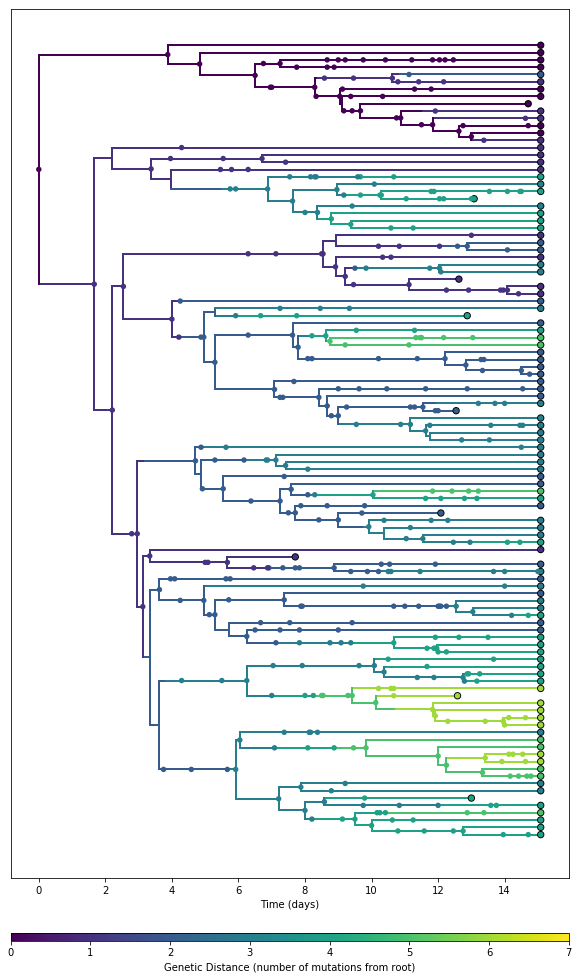

In [9]:
##Choose random percentage of alive_cells and collect the parents of these cells
fraction = 0.1
cells_copy = copy.deepcopy(cells_CC)

sample = random.sample(cells_copy, int(fraction*float(len(cells_copy))))
pruned_cells = []
genealogy_tree_CC = bt.tree() #initiate tree object to track cellular replication
cur_index = 0


for cell in sample: #get all ancestor cells from randomly samples leaves
    curcell = cell
    while curcell != None:
        pruned_cells.append(curcell)
        curcell.node = None
        curcell = curcell.parent
        
pruned_cells = np.unique(pruned_cells)
postorder_nodes = sorted(pruned_cells, key=operator.attrgetter('birthdate'), reverse = True)

for cell in pruned_cells:
    cell.children = []
    
for cell in sample: #get all ancestor cells from randomly samples leaves
    curcell = cell
    while curcell.parent != None:
        if not curcell in curcell.parent.children:
            curcell.parent.children.append(curcell)
        curcell = curcell.parent


for leaf in sample: #make leaf and node for each terminal cell sample and it's proximal division
    new_leaf = bt.leaf()
    new_leaf.x = leaf.deathdate
    new_leaf.height = leaf.deathdate
    new_leaf.mutations = leaf.mutations
    new_leaf.index = cur_index
    new_leaf.numName = cur_index
    cur_index += 1
    new_leaf.locx = leaf.locx
    new_leaf.locy = leaf.locy
    leaf.leaf = new_leaf
    genealogy_tree_CC.Objects.append(new_leaf)
    genealogy_tree_CC.leaves.append(new_leaf)

for cell in postorder_nodes: #make nodes for each cell division and add node lineages
    new_node = bt.node()
    new_node.x = cell.birthdate
    new_node.height = cell.birthdate 
    new_node.real_cell = True
    new_node.index = cur_index
    cur_index += 1
    sorted_children =  sorted(cell.children, key=operator.attrgetter('cellnum'), reverse = False)
    cell.node = new_node
    if len(sorted_children) > 0:
        new_node.mutations = list(set(cell.mutations) & set(sorted_children[0].mutations))
    else:
        new_node.mutations = cell.mutations
    parents = [new_node]
    for i in range(len(sorted_children)):
#         if ((i < (len(sorted_children)) -1 ) or (cell in sample)):
        if (i < len(sorted_children) -1 ) or (cell in sample):
            renew_node = bt.node()
            renew_node.x = sorted_children[i].birthdate
            renew_node.height = sorted_children[i].birthdate
            renew_node.mutations = cell.mutations
            renew_node.length = sorted_children[i].birthdate - parents[i].height
            renew_node.index = cur_index
            renew_node.parent = parents[i]
            if i < len(sorted_children) -1:
                renew_node.mutations = list(set(cell.mutations) & set(sorted_children[i+1].mutations))
            else:
                renew_node.mutations = cell.mutations
            renew_node.real_cell = False
            parents[i].children.append(renew_node)
            cur_index += 1
            parents.append(renew_node)
            genealogy_tree_CC.Objects.append(renew_node)
            genealogy_tree_CC.nodes.append(renew_node)
        sorted_children[i].node.parent = parents[i]
        sorted_children[i].node.length = sorted_children[i].node.height - parents[i].height
        parents[i].children.append(sorted_children[i].node)
    if cell in sample:
        parents[-1].children.append(cell.leaf)
        cell.leaf.parent = parents[-1]
        cell.leaf.length = cell.leaf.height - parents[-1].height
    if cell.cellnum== 0:
        genealogy_tree_CC.root = new_node
        new_node.length = sorted_children[0].birthdate
    genealogy_tree_CC.Objects.append(new_node)
    genealogy_tree_CC.nodes.append(new_node)

genealogy_tree_CC.treeHeight = sorted(sample, key=operator.attrgetter('deathdate'), reverse = True)[0].deathdate
genealogy_tree_CC.traverse_tree()
genealogy_tree_CC.drawTree()
genealogy_tree_CC.sortBranches() 

fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors


max_muts_all = 0
for a in alive_cells_CC:
    if max_muts_all < len(a.mutations):
        max_muts_all = len(a.mutations)

for k in genealogy_tree_CC.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x

    c =  cmap(len(k.mutations)/float(max_muts_all))

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        if k.real_cell == True:
            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,genealogy_tree_CC.ySpan+5)

import matplotlib.colors as mcolors
import matplotlib.cm as cm

##set up colorbar
norm= mcolors.Normalize(vmin=0, vmax=max_muts_all)
scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
scalarmappaple.set_array(range(max_muts_all))
cbar = plt.colorbar(scalarmappaple,aspect = 70,orientation = 'horizontal',pad = 0.05)
cbar.set_label('Genetic Distance (number of mutations from root)', rotation=0)
#cbar.ax.text(3,0.75,'Genetic Distance (number of mutations from root)',rotation=90)

# ax.spines['top'].set_visible(False) ## no axes
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.set_xlabel('Time (days)')


#ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
#ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('figures/simultation_genealogy_tree_CC.png')
plt.show()

    


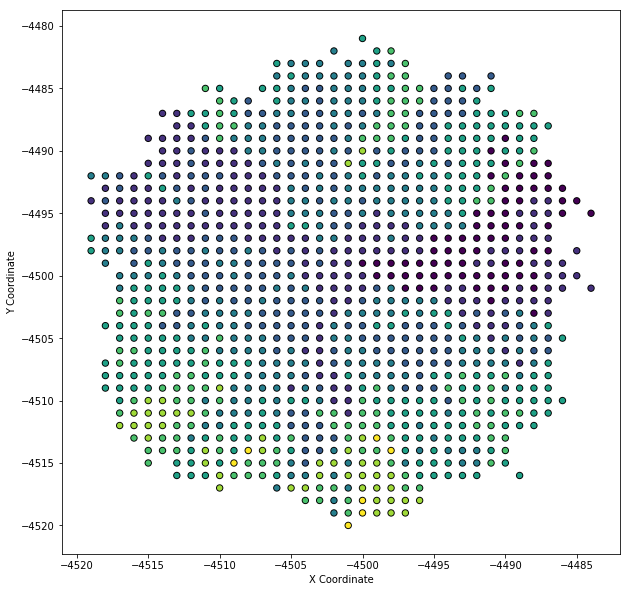

In [10]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}

startx = 5000
starty = 5000
for a in alive_cells_CC:
    c =  cmap(len(a.mutations)/float(max_muts_all))
# default branch width
    x = a.locx - startx
    y = a.locy - starty
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    ax.set_ylabel('Y Coordinate')
    ax.set_xlabel('X Coordinate')
    
plt.savefig('figures/CCsimultation_alive_cells.png')
plt.show()

In [11]:
cells_CSC, alive_cells_CSC, lattice_CSC = cancer_sim(founder_cells = 1,max_cells = 1000,proliferationCSC = 1,proliferationCC = 1,CSC = True,pmax = 10,mutation = 0.1,ps = 0.1,mortality = 0.5)

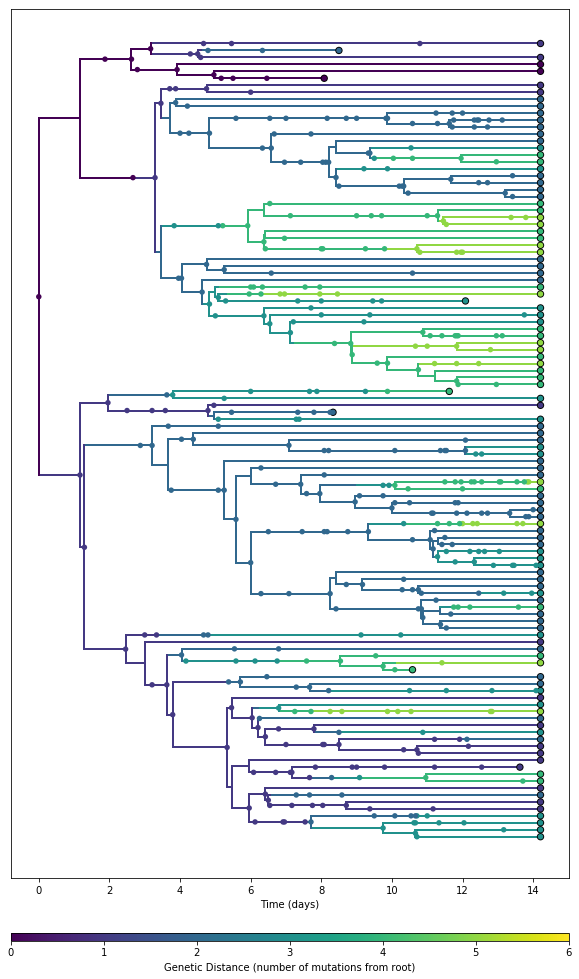

In [12]:
##Choose random percentage of alive_cells and collect the parents of these cells
fraction = 0.1
cells_copy = copy.deepcopy(cells_CSC)

sample = random.sample(cells_copy, int(fraction*float(len(cells_copy))))
pruned_cells = []
genealogy_tree_CSC = bt.tree() #initiate tree object to track cellular replication
cur_index = 0


for cell in sample: #get all ancestor cells from randomly samples leaves
    curcell = cell
    while curcell != None:
        pruned_cells.append(curcell)
        curcell.node = None
        curcell = curcell.parent
        
pruned_cells = np.unique(pruned_cells)
postorder_nodes = sorted(pruned_cells, key=operator.attrgetter('birthdate'), reverse = True)

for cell in pruned_cells:
    cell.children = []
    
for cell in sample: #get all ancestor cells from randomly samples leaves
    curcell = cell
    while curcell.parent != None:
        if not curcell in curcell.parent.children:
            curcell.parent.children.append(curcell)
        curcell = curcell.parent


for leaf in sample: #make leaf and node for each terminal cell sample and it's proximal division
    new_leaf = bt.leaf()
    new_leaf.x = leaf.deathdate
    new_leaf.height = leaf.deathdate
    new_leaf.mutations = leaf.mutations
    new_leaf.index = cur_index
    new_leaf.numName = cur_index
    cur_index += 1
    new_leaf.locx = leaf.locx
    new_leaf.locy = leaf.locy
    leaf.leaf = new_leaf
    new_leaf.alive = leaf.alive
    genealogy_tree_CSC.Objects.append(new_leaf)
    genealogy_tree_CSC.leaves.append(new_leaf)

for cell in postorder_nodes: #make nodes for each cell division and add node lineages
    new_node = bt.node()
    new_node.x = cell.birthdate
    new_node.height = cell.birthdate 
    new_node.mutations = cell.mutations
    new_node.real_cell = True
    new_node.index = cur_index
    cur_index += 1
    sorted_children =  sorted(cell.children, key=operator.attrgetter('cellnum'), reverse = False)
    if len(sorted_children) > 0:
        new_node.mutations = list(set(cell.mutations) & set(sorted_children[0].mutations))
    else:
        new_node.mutations = cell.mutations
    cell.node = new_node
    parents = [new_node]
    for i in range(len(sorted_children)):
#         if ((i < (len(sorted_children)) -1 ) or (cell in sample)):
        if (i < len(sorted_children) -1 ) or (cell in sample):
            renew_node = bt.node()
            renew_node.x = sorted_children[i].birthdate
            renew_node.height = sorted_children[i].birthdate
            renew_node.mutations = cell.mutations
            renew_node.length = sorted_children[i].birthdate - parents[i].height
            renew_node.index = cur_index
            renew_node.parent = parents[i]
            renew_node.real_cell = False
            if i < len(sorted_children) -1:
                renew_node.mutations = list(set(cell.mutations) & set(sorted_children[i+1].mutations))
            else:
                renew_node.mutations = cell.mutations
            parents[i].children.append(renew_node)
            cur_index += 1
            parents.append(renew_node)
            genealogy_tree_CSC.Objects.append(renew_node)
            genealogy_tree_CSC.nodes.append(renew_node)
        sorted_children[i].node.parent = parents[i]
        sorted_children[i].node.length = sorted_children[i].node.height - parents[i].height
        parents[i].children.append(sorted_children[i].node)
    if cell in sample:
        parents[-1].children.append(cell.leaf)
        cell.leaf.parent = parents[-1]
        cell.leaf.length = cell.leaf.height - parents[-1].height
    if cell.cellnum== 0:
        genealogy_tree_CSC.root = new_node
        new_node.length = 0
    genealogy_tree_CSC.Objects.append(new_node)
    genealogy_tree_CSC.nodes.append(new_node)

genealogy_tree_CSC.treeHeight = sorted(sample, key=operator.attrgetter('deathdate'), reverse = True)[0].deathdate
genealogy_tree_CSC.traverse_tree()
genealogy_tree_CSC.drawTree() 
genealogy_tree_CSC.sortBranches()

fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors
# max_muts = 0
# for k in genealogy_tree_CC.Objects:
#     if max_muts < len(k.mutations):
#         max_muts = len(k.mutations)

max_muts_all = 0
for a in alive_cells_CSC:
    if max_muts_all < len(a.mutations):
        max_muts_all = len(a.mutations)

for k in genealogy_tree_CSC.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x

    c =  cmap(len(k.mutations)/float(max_muts_all))

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        if k.real_cell == True:
            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,genealogy_tree_CSC.ySpan+5)

import matplotlib.colors as mcolors
import matplotlib.cm as cm

##set up colorbar
norm= mcolors.Normalize(vmin=0, vmax=max_muts_all)
scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
scalarmappaple.set_array(range(max_muts_all))
cbar = plt.colorbar(scalarmappaple,aspect = 70,orientation = 'horizontal',pad = 0.05)
cbar.set_label('Genetic Distance (number of mutations from root)', rotation=0)
#cbar.ax.text(3,0.75,'Genetic Distance (number of mutations from root)',rotation=90)

# ax.spines['top'].set_visible(False) ## no axes
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.set_xlabel('Time (days)')


#ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
#ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('figures/simultation_genealogy_tree_CSC.png')
plt.show()

    


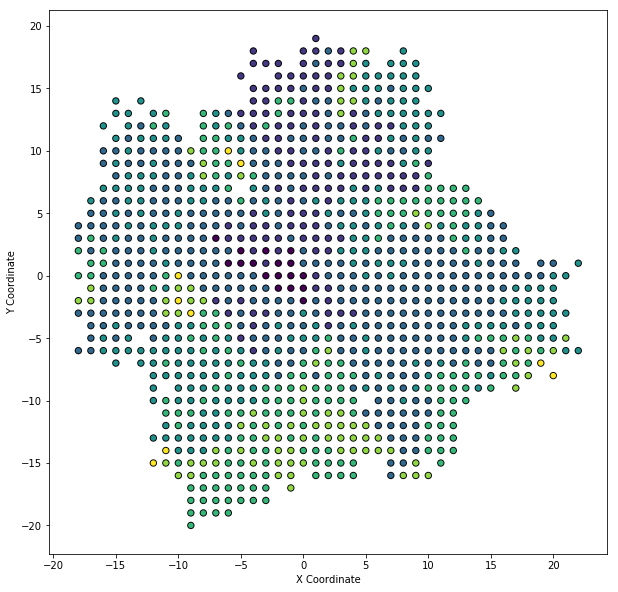

In [13]:

fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}

startx = 500
starty = 500
for a in alive_cells_CSC:
    c =  cmap(len(a.mutations)/float(max_muts_all))
# default branch width
    x = a.locx - startx
    y = a.locy - starty
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
ax.set_ylabel('Y Coordinate')
ax.set_xlabel('X Coordinate')
# norm= mcolors.Normalize(vmin=0, vmax=max_muts_all)
# scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
# scalarmappaple.set_array(range(max_muts_all))
# cbar = plt.colorbar(scalarmappaple,aspect = 70,orientation = 'horizontal',pad = 0.1)
# cbar.set_label('Genetic Distance (number of mutations from root)', rotation=0)
    
plt.savefig('figures/CSCsimultation_alive_cells.png')
plt.show()

### Spatial LBI rank

In [14]:
### create full tree to determine genetic distance and true LBI
def cells_to_tree(cells, frac = 1.0):
        ##Choose random percentage of alive_cells and collect the parents of these cells
    fraction = frac
    cells_copy = copy.deepcopy(cells)

    sample = random.sample(cells_copy, int(fraction*float(len(cells_copy))))
    pruned_cells = []
    tree = bt.tree() #initiate tree object to track cellular replication
    cur_index = 0


    for cell in sample: #get all ancestor cells from randomly samples leaves
        curcell = cell
        while curcell != None:
            pruned_cells.append(curcell)
            curcell.node = None
            curcell = curcell.parent

    pruned_cells = np.unique(pruned_cells)
    postorder_nodes = sorted(pruned_cells, key=operator.attrgetter('birthdate'), reverse = True)

    for cell in pruned_cells:
        cell.children = []

    for cell in sample: #get all ancestor cells from randomly samples leaves
        curcell = cell
        while curcell.parent != None:
            if not curcell in curcell.parent.children:
                curcell.parent.children.append(curcell)
            curcell = curcell.parent


    for leaf in sample: #make leaf and node for each terminal cell sample and it's proximal division
        new_leaf = bt.leaf()
        new_leaf.x = leaf.deathdate
        new_leaf.height = leaf.deathdate
        new_leaf.mutations = leaf.mutations
        new_leaf.index = cur_index
        new_leaf.numName = cur_index
        cur_index += 1
        new_leaf.locx = leaf.locx
        new_leaf.locy = leaf.locy
        leaf.leaf = new_leaf
        new_leaf.alive = leaf.alive
        tree.Objects.append(new_leaf)
        tree.leaves.append(new_leaf)

    for cell in postorder_nodes: #make nodes for each cell division and add node lineages
        new_node = bt.node()
        new_node.x = cell.birthdate
        new_node.height = cell.birthdate 
        new_node.mutations = cell.mutations
        new_node.real_cell = True
        new_node.index = cur_index
        cur_index += 1
        sorted_children =  sorted(cell.children, key=operator.attrgetter('cellnum'), reverse = False)
        if len(sorted_children) > 0:
            new_node.mutations = list(set(cell.mutations) & set(sorted_children[0].mutations))
        else:
            new_node.mutations = cell.mutations
        cell.node = new_node
        parents = [new_node]
        for i in range(len(sorted_children)):
    #         if ((i < (len(sorted_children)) -1 ) or (cell in sample)):
            if (i < len(sorted_children) -1 ) or (cell in sample):
                renew_node = bt.node()
                renew_node.x = sorted_children[i].birthdate
                renew_node.height = sorted_children[i].birthdate
                renew_node.mutations = cell.mutations
                renew_node.length = sorted_children[i].birthdate - parents[i].height
                renew_node.index = cur_index
                renew_node.parent = parents[i]
                renew_node.real_cell = False
                if i < len(sorted_children) -1:
                    renew_node.mutations = list(set(cell.mutations) & set(sorted_children[i+1].mutations))
                else:
                    renew_node.mutations = cell.mutations
                parents[i].children.append(renew_node)
                cur_index += 1
                parents.append(renew_node)
                tree.Objects.append(renew_node)
                tree.nodes.append(renew_node)
            sorted_children[i].node.parent = parents[i]
            sorted_children[i].node.length = sorted_children[i].node.height - parents[i].height
            parents[i].children.append(sorted_children[i].node)
        if cell in sample:
            parents[-1].children.append(cell.leaf)
            cell.leaf.parent = parents[-1]
            cell.leaf.length = cell.leaf.height - parents[-1].height
        if cell.cellnum== 0:
            tree.root = new_node
            new_node.length = 0
        tree.Objects.append(new_node)
        tree.nodes.append(new_node)

    tree.treeHeight = sorted(sample, key=operator.attrgetter('deathdate'), reverse = True)[0].deathdate
    tree.traverse_tree()
    tree.drawTree() 
    tree.sortBranches()
    return tree
    

In [15]:
full_gen_tree_CSC = cells_to_tree(cells_CSC)

In [16]:
full_gen_tree_CC = cells_to_tree(cells_CC)


In [17]:
ttree_CSC = calc_LBI(full_gen_tree_CSC,tau = 2 )
rtree_CSC = rank_LBI(ttree_CSC)

In [18]:
ttree_CC = calc_LBI(full_gen_tree_CC,tau = 0.5)
rtree_CC = rank_LBI(ttree_CC)

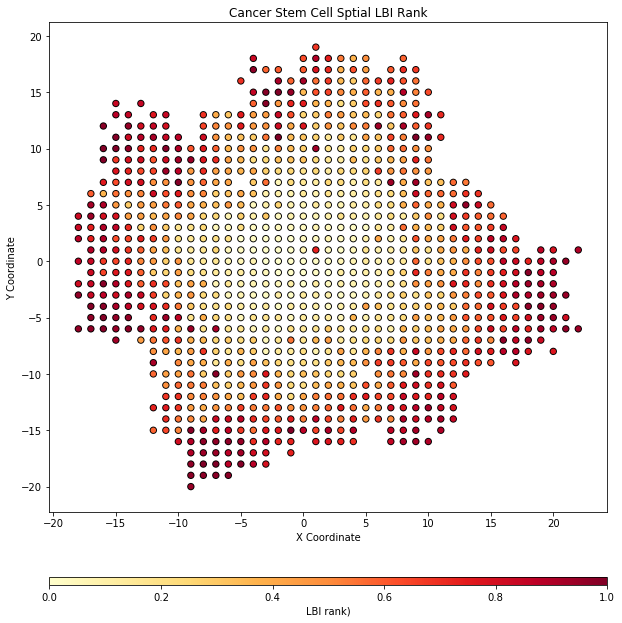

In [44]:

fig1,ax = plt.subplots(figsize=(10,12),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
cmap2=mpl.cm.YlOrRd
startx = 500
starty = 500
for a in rtree_CSC.leaves:
    if a.alive:
        c =  cmap2(a.rank)
    # default branch width
        x = a.locx - startx
        y = a.locy - starty
        s = 30
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
ax.set_ylabel('Y Coordinate')
ax.set_xlabel('X Coordinate')
ax.set_title('Cancer Stem Cell Sptial LBI Rank')
norm= mcolors.Normalize(vmin=0, vmax=1)
scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap2)
scalarmappaple.set_array(range(1))
cbar = plt.colorbar(scalarmappaple,aspect = 70,orientation = 'horizontal',pad = 0.1)
cbar.set_label('LBI rank)', rotation=0)
    
plt.savefig('figures/simultation_spatial_LBI_CSC.png')
plt.show()

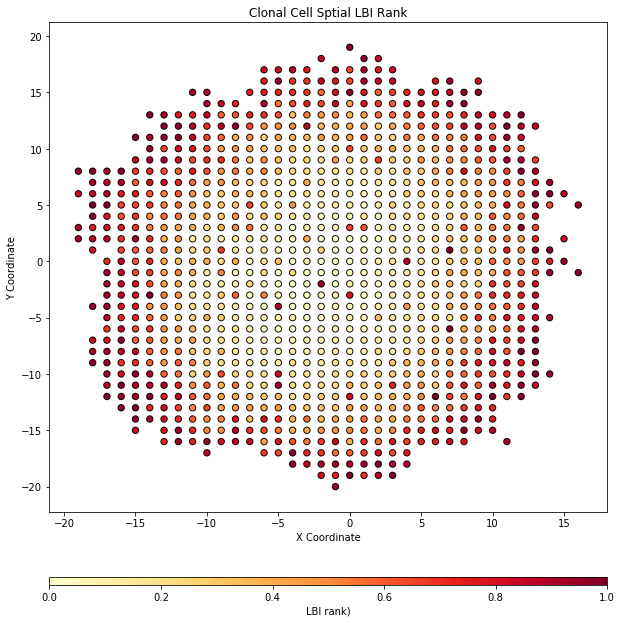

In [43]:

fig1,ax = plt.subplots(figsize=(10,12),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
cmap2=mpl.cm.YlOrRd
startx = 500
starty = 500
for a in rtree_CC.leaves:
    if a.alive:
        c =  cmap2(a.rank)
    # default branch width
        x = a.locx - startx
        y = a.locy - starty
        s = 30
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
ax.set_ylabel('Y Coordinate')
ax.set_xlabel('X Coordinate')
ax.set_title('Clonal Cell Sptial LBI Rank')
norm= mcolors.Normalize(vmin=0, vmax=1)
scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap2)
scalarmappaple.set_array(range(1))
cbar = plt.colorbar(scalarmappaple,aspect = 70,orientation = 'horizontal',pad = 0.1)
cbar.set_label('LBI rank)', rotation=0)
    
plt.savefig('figures/simultation_spatial_LBI_CC.png')
plt.show()

In [21]:
def calc_distance(x,y,startx = 0, starty = 0):
    xdistance = abs(x - startx)
    ydistance = abs(y - starty)
    distance = math.sqrt((xdistance ** 2) + (ydistance ** 2))
    return distance    

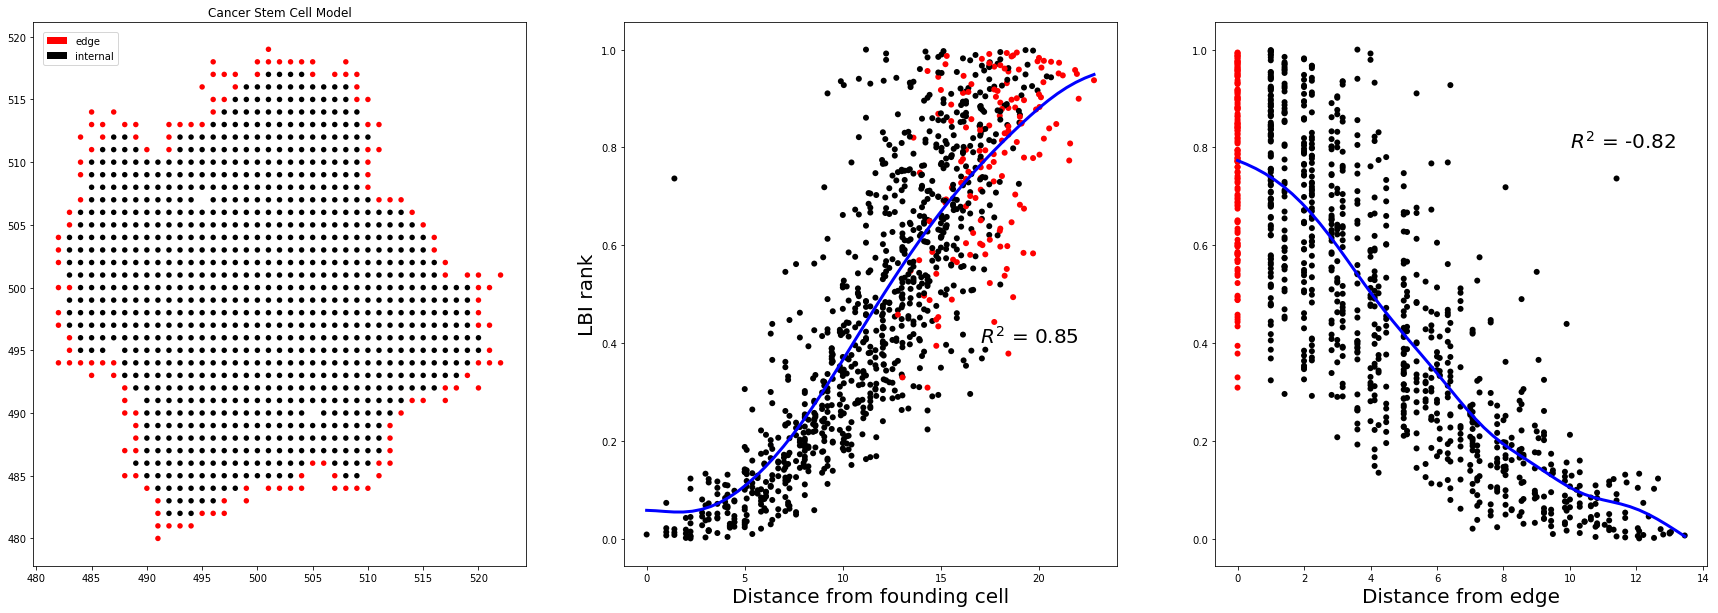

In [27]:
distance_vector = []
rank_vector = []
color_vector = []
edge_cells = []
edge_distance = []
fig1,ax = plt.subplots(1,3,figsize=(30,10),facecolor='w')
for a in rtree_CSC.leaves:
    if a.alive:
        distance = calc_distance(a.locx,a.locy,500,500)
        distance_vector.append(distance)
        rank_vector.append(a.rank)
        free_cells = adjacent_cell(lattice_CSC,a.locx,a.locy)
        if len(free_cells) > 1:
            edge_cells.append(a)
            c = 'red'
        else:
            c = 'k'
        color_vector.append(c)
        ax[0].scatter(a.locx,a.locy,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
for a in rtree_CSC.leaves:
    if a.alive:
        edist = 1000000000
        for e in edge_cells:
            edist_prop = calc_distance(a.locx,a.locy,e.locx,e.locy)
            if edist_prop < edist:
                edist = edist_prop
        edge_distance.append(edist)

maxE = max(edge_distance)
maxD = max(distance_vector)
ax[1].scatter(distance_vector,rank_vector,facecolor=color_vector,edgecolor='none') ## plot circle for every tip
ax[2].scatter(edge_distance,rank_vector,facecolor=color_vector,edgecolor='none') ## plot circle for every tip

ax[1].set_xlabel('Distance from founding cell',size = 20)
ax[2].set_xlabel('Distance from edge',size = 20)
ax[1].set_ylabel('LBI rank', size = 20)

r1 =  np.corrcoef(distance_vector,rank_vector)[1,0]
r2 =  np.corrcoef(edge_distance,rank_vector)[1,0]
ax[1].text(17,0.4,'$R^2$ = %.2f'%r1,fontsize = 20)
ax[2].text(10,0.8,'$R^2$ = %.2f'%r2,fontsize = 20)

han_list = []

from statsmodels.nonparametric.api import KernelReg

xgrid = np.linspace(0,maxD)
model = KernelReg(rank_vector,distance_vector,var_type = 'c',reg_type = 'll')
reg_vals, x = model.fit(data_predict = xgrid)
ax[1].plot(xgrid,reg_vals, "b-", linewidth=3.0,zorder = 12)
xgrid = np.linspace(0,maxE)
model = KernelReg(rank_vector,edge_distance,var_type = 'c',reg_type = 'll')
reg_vals, x = model.fit(data_predict = xgrid)
ax[2].plot(xgrid,reg_vals, "b-", linewidth=3.0,zorder = 12)
ax[0].set_title('Cancer Stem Cell Model')


legend_dict = {"edge" : "red", "internal" : "k"}
for key in legend_dict:
    marker = mpl.patches.Ellipse((0.5,0.5),0.5,0.5,facecolor=legend_dict[key],label = key)
    #marker = mlines.Line2D(range(1), range(1), color = None, marker='o', markerfacecolor = legend_dict[key], label = key, markeredgecolor='k',markersize = 8)
    han_list.append(marker)

#ax[0].legend(handles = han_list, markerfirst = True, loc='upper left', borderaxespad= 1)
ax[0].legend(handles = han_list, markerfirst = True, loc='upper left', borderaxespad= 1)
plt.savefig('figures/CSCsimultation_distance_LBI.png')
plt.show()
    

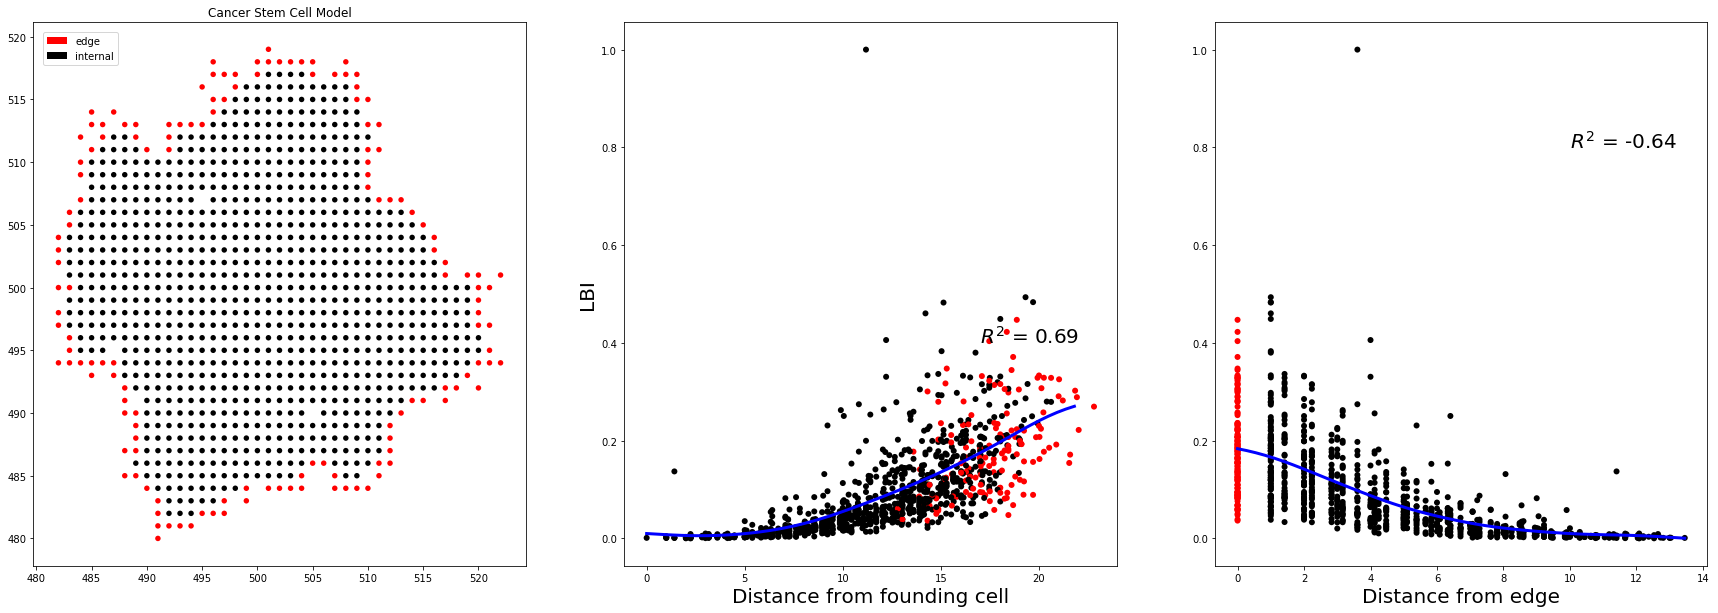

In [28]:
distance_vector = []
lbi_vector = []
color_vector = []
edge_cells = []
edge_distance = []
s = 30
fig1,ax = plt.subplots(1,3,figsize=(30,10),facecolor='w')
for a in ttree_CSC.leaves:
    if a.alive:
        distance = calc_distance(a.locx,a.locy,500,500)
        distance_vector.append(distance)
        lbi_vector.append(a.lb)
        free_cells = adjacent_cell(lattice_CSC,a.locx,a.locy)
        if len(free_cells) > 1:
            edge_cells.append(a)
            c = 'red'
        else:
            c = 'k'
        color_vector.append(c)
        ax[0].scatter(a.locx,a.locy,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
for a in ttree_CSC.leaves:
    if a.alive:
        edist = 1000000000
        for e in edge_cells:
            edist_prop = calc_distance(a.locx,a.locy,e.locx,e.locy)
            if edist_prop < edist:
                edist = edist_prop

        edge_distance.append(edist)
maxL = max(lbi_vector)
minL = min(lbi_vector)
lbi_vector_norm = (lbi_vector - minL)/(maxL - minL)
maxE = max(edge_distance)
maxD = max(distance_vector)
ax[1].scatter(distance_vector,lbi_vector_norm,facecolor=color_vector,edgecolor='none') ## plot circle for every tip
ax[2].scatter(edge_distance,lbi_vector_norm,facecolor=color_vector,edgecolor='none') ## plot circle for every tip
#ax[1].plot(np.unique(distance_vector), np.poly1d(np.polyfit(distance_vector, rank_vector, 2))(np.unique(distance_vector)),color = 'orange')
#ax.set_title('LBI vs. distance from founding cell')
ax[1].set_xlabel('Distance from founding cell',size = 20)
ax[2].set_xlabel('Distance from edge',size = 20)
ax[1].set_ylabel('LBI', size = 20)

r1 =  np.corrcoef(distance_vector,lbi_vector_norm)[1,0]
r2 =  np.corrcoef(edge_distance,lbi_vector_norm)[1,0]
ax[1].text(17,0.4,'$R^2$ = %.2f'%r1,fontsize = 20)
ax[2].text(10,0.8,'$R^2$ = %.2f'%r2,fontsize = 20)

han_list = []

from statsmodels.nonparametric.api import KernelReg

xgrid = np.linspace(0,maxD-1)
model = KernelReg(lbi_vector_norm,distance_vector,var_type = 'c',reg_type = 'll')
reg_vals, x = model.fit(data_predict = xgrid)
ax[1].plot(xgrid,reg_vals, "b-", linewidth=3.0,zorder = 12)
xgrid = np.linspace(0,maxE)
model = KernelReg(lbi_vector_norm,edge_distance,var_type = 'c',reg_type = 'll')
reg_vals, x = model.fit(data_predict = xgrid)
ax[2].plot(xgrid,reg_vals, "b-", linewidth=3.0,zorder = 12)
ax[0].set_title('Cancer Stem Cell Model')

s = 30
legend_dict = {"edge" : "red", "internal" : "k"}
for key in legend_dict:
    marker = mpl.patches.Ellipse((0.5,0.5),0.5,0.5,facecolor=legend_dict[key],label = key)
    #marker = mlines.Line2D(range(1), range(1), color = None, marker='o', markerfacecolor = legend_dict[key], label = key, markeredgecolor='k',markersize = 8)
    han_list.append(marker)

#ax[0].legend(handles = han_list, markerfirst = True, loc='upper left', borderaxespad= 1)
ax[0].legend(handles = han_list, markerfirst = True, loc='upper left', borderaxespad= 1)
plt.savefig('figures/CSCsimultation_distance_LBI_raw.png')
plt.show()
    

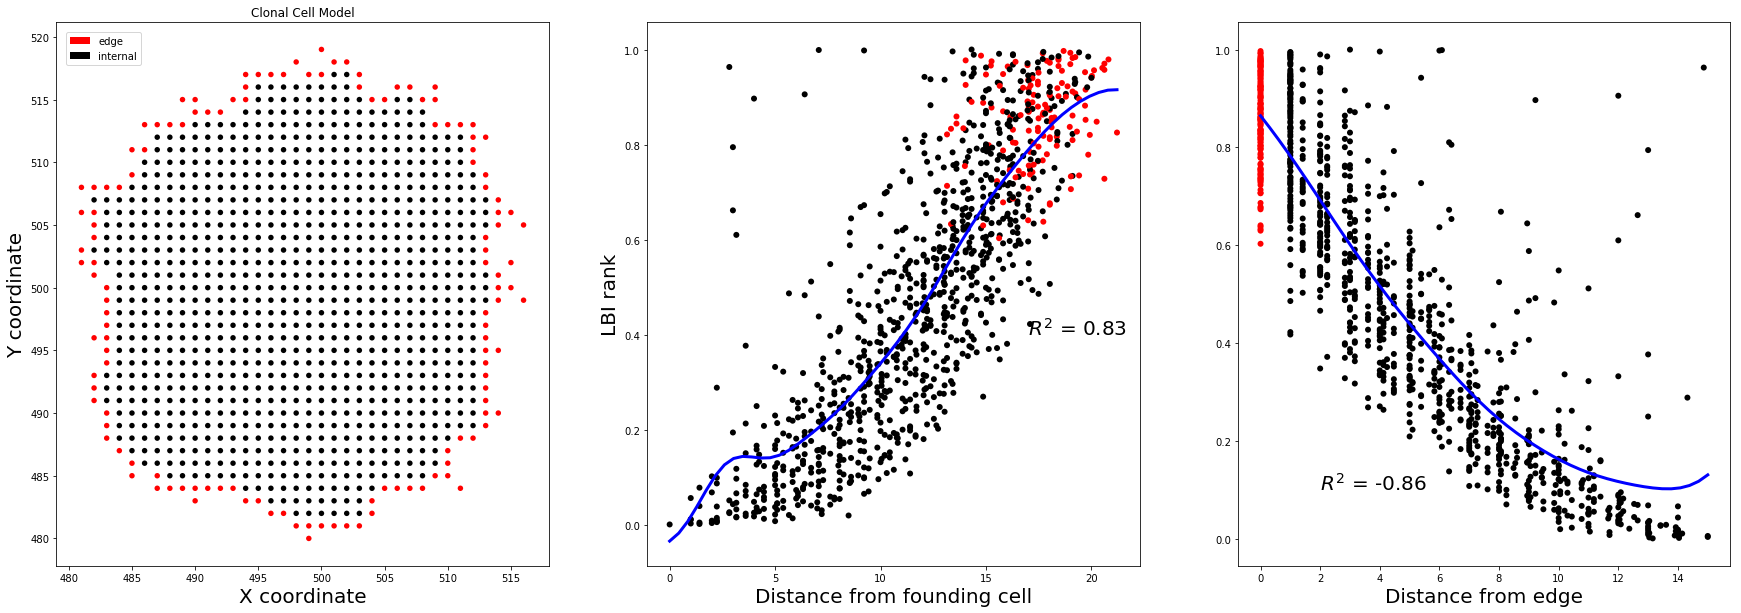

In [29]:
distance_vector = []
rank_vector = []
color_vector = []
edge_cells = []
edge_distance = []
fig1,ax = plt.subplots(1,3,figsize=(30,10),facecolor='w')
for a in rtree_CC.leaves:
    if a.alive:
        distance = calc_distance(a.locx,a.locy,500,500)
        distance_vector.append(distance)
        rank_vector.append(a.rank)
        free_cells = adjacent_cell(lattice_CC,a.locx,a.locy)
        if len(free_cells) > 1:
            edge_cells.append(a)
            c = 'red'
        else:
            c = 'k'
        color_vector.append(c)
        ax[0].scatter(a.locx,a.locy,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
for a in rtree_CC.leaves:
    if a.alive:
        edist = 100000
        for e in edge_cells:
            edist_prop = calc_distance(a.locx,a.locy,e.locx,e.locy)
            if edist_prop < edist:
                edist = edist_prop
        edge_distance.append(edist)
         
ax[1].scatter(distance_vector,rank_vector,facecolor=color_vector,edgecolor='none') ## plot circle for every tip
ax[2].scatter(edge_distance,rank_vector,facecolor=color_vector,edgecolor='none') ## plot circle for every tip
#ax[1].plot(np.unique(distance_vector), np.poly1d(np.polyfit(distance_vector, rank_vector, 2))(np.unique(distance_vector)),color = 'orange')
#ax.set_title('LBI vs. distance from founding cell')
ax[1].set_xlabel('Distance from founding cell',size = 20)
ax[2].set_xlabel('Distance from edge',size = 20)
ax[1].set_ylabel('LBI rank', size = 20)
ax[0].set_xlabel('X coordinate',size = 20)
ax[0].set_ylabel('Y coordinate',size = 20)
ax[0].set_title('Clonal Cell Model')

r1 =  np.corrcoef(distance_vector,rank_vector)[1,0]
r2 =  np.corrcoef(edge_distance,rank_vector)[1,0]
ax[1].text(17,0.4,'$R^2$ = %.2f'%r1,fontsize = 20)
ax[2].text(2,0.1,'$R^2$ = %.2f'%r2,fontsize = 20)

han_list = []

from statsmodels.nonparametric.api import KernelReg

xgrid = np.linspace(0,max(distance_vector))
model = KernelReg(rank_vector,distance_vector,var_type = 'c',reg_type = 'll')
reg_vals, x = model.fit(data_predict = xgrid)
ax[1].plot(xgrid,reg_vals, "b-", linewidth=3.0,zorder = 12)
xgrid = np.linspace(0,max(edge_distance))
model = KernelReg(rank_vector,edge_distance,var_type = 'c',reg_type = 'll')
reg_vals, x = model.fit(data_predict = xgrid)
ax[2].plot(xgrid,reg_vals, "b-", linewidth=3.0,zorder = 12)


legend_dict = {"edge" : "red", "internal" : "k"}
for key in legend_dict:
    marker = mpl.patches.Ellipse((0.5,0.5),0.5,0.5,facecolor=legend_dict[key],label = key)
    #marker = mlines.Line2D(range(1), range(1), color = None, marker='o', markerfacecolor = legend_dict[key], label = key, markeredgecolor='k',markersize = 8)
    han_list.append(marker)

#ax[0].legend(handles = han_list, markerfirst = True, loc='upper left', borderaxespad= 1)
ax[0].legend(handles = han_list, markerfirst = True, loc='upper left', borderaxespad= 1)
plt.savefig('figures/CCsimultation_distance_LBI.png')
plt.show()

In [49]:
spatial_vector = []
genetic_vector = []

for node in rtree_CC.nodes:
    nonleaf1 = isinstance(node.children[0],bt.node)
    if nonleaf1:
        for index1 in [x for x in node.children[0].leaves if x%10 == 0]:
            for index2 in node.children[1].leaves:
                leaf1 = [x for x in rtree_CC.leaves if x.index == index1][0]
                leaf2 = [x for x in rtree_CC.leaves if x.index == index2][0]
                distance = calc_distance(leaf1.locx,leaf1.locy,leaf2.locx,leaf2.locy)
                spatial_vector.append(distance)
                genetic = (leaf1.height - node.height) + (leaf2.height - node.height)
                genetic_vector.append(genetic)



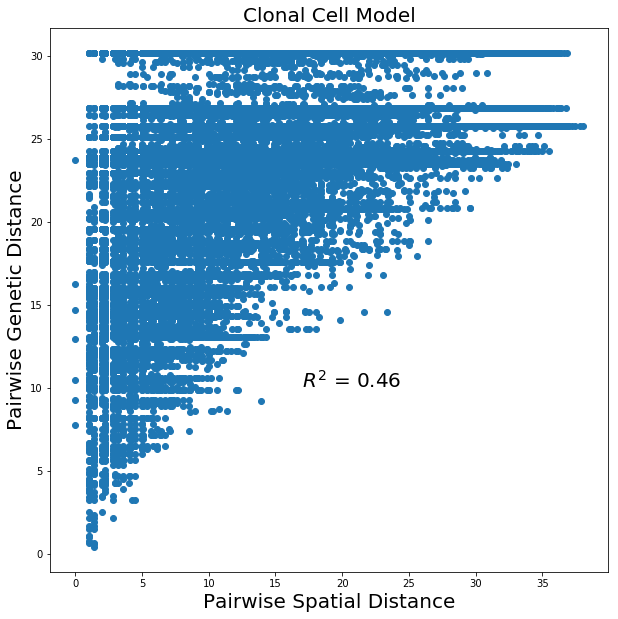

In [50]:
fig1,ax = plt.subplots(1,figsize=(10,10),facecolor='w')   
ax.scatter(spatial_vector,genetic_vector)         
ax.set_xlabel('Pairwise Spatial Distance',size = 20)
ax.set_ylabel('Pairwise Genetic Distance', size = 20)
ax.set_title('Clonal Cell Model', size = 20)

r1 =  np.corrcoef(spatial_vector,genetic_vector)[1,0]
ax.text(17,10,'$R^2$ = %.2f'%r1,fontsize = 20)


from statsmodels.nonparametric.api import KernelReg

# xgrid = np.linspace(0,int(max(spatial_vector)))
# model = KernelReg(genetic_vector,spatial_vector,var_type = 'c',reg_type = 'll')
# reg_vals, x = model.fit(data_predict = xgrid)
# ax.plot(xgrid,reg_vals, "b-", linewidth=3.0,zorder = 12)

plt.savefig('figures/CCsimultation_genetic_pair.png')
plt.show()

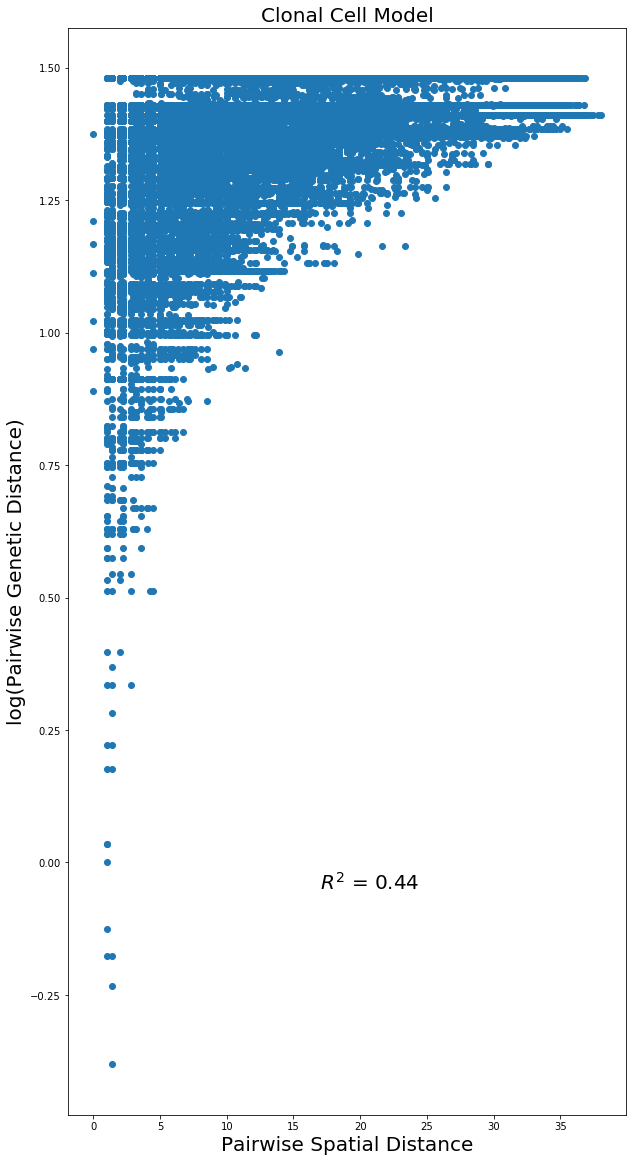

In [57]:
fig1,ax = plt.subplots(1,figsize=(10,20),facecolor='w')
genetic_vector_log = [math.log(y,10) for y in genetic_vector] 
ax.scatter(spatial_vector,genetic_vector_log)         
ax.set_xlabel('Pairwise Spatial Distance',size = 20)
ax.set_ylabel('log(Pairwise Genetic Distance)', size = 20)
ax.set_title('Clonal Cell Model', size = 20)

r1 =  np.corrcoef(spatial_vector,genetic_vector_log)[1,0]
ax.text(17,-0.05,'$R^2$ = %.2f'%r1,fontsize = 20)


# xgrid = np.linspace(0,int(max(spatial_vector)))
# model = KernelReg(genetic_vector,spatial_vector,var_type = 'c',reg_type = 'll')
# reg_vals, x = model.fit(data_predict = xgrid)
# ax.plot(xgrid,reg_vals, "b-", linewidth=3.0,zorder = 12)

plt.savefig('figures/CCsimultation_genetic_pair_log.png')
plt.show()

In [54]:
spatial_vector_CSC = []
genetic_vector_CSC = []

for node in rtree_CSC.nodes:
    nonleaf1 = isinstance(node.children[0],bt.node)
    if nonleaf1:
        for index1 in [x for x in node.children[0].leaves if x%10 == 0]:
            for index2 in node.children[1].leaves:
                leaf1 = [x for x in rtree_CSC.leaves if x.index == index1][0]
                leaf2 = [x for x in rtree_CSC.leaves if x.index == index2][0]
                distance = calc_distance(leaf1.locx,leaf1.locy,leaf2.locx,leaf2.locy)
                spatial_vector_CSC.append(distance)
                genetic = (leaf1.height - node.height) + (leaf2.height - node.height)
                genetic_vector_CSC.append(genetic)



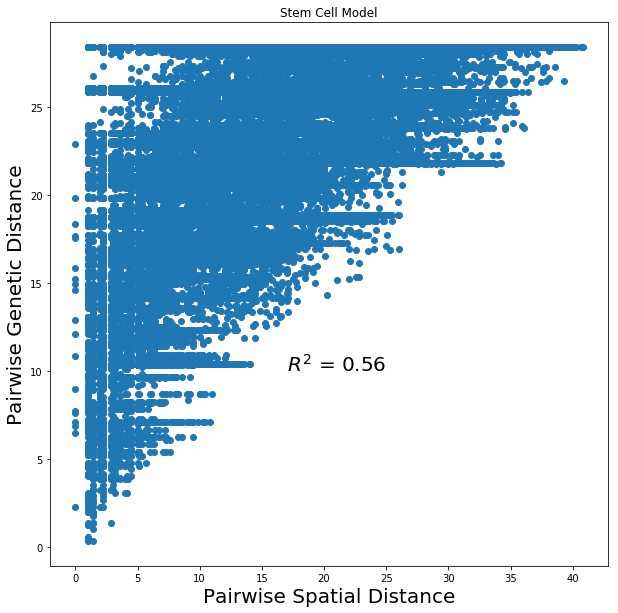

In [45]:
fig1,ax = plt.subplots(1,figsize=(10,10),facecolor='w')
ax.scatter(spatial_vector_CSC,genetic_vector_CSC)         
ax.set_xlabel('Pairwise Spatial Distance',size = 20)
ax.set_ylabel('Pairwise Genetic Distance', size = 20)
ax.set_title('Stem Cell Model')

r1 =  np.corrcoef(spatial_vector_CSC,genetic_vector_CSC)[1,0]
ax.text(17,10,'$R^2$ = %.2f'%r1,fontsize = 20)


from statsmodels.nonparametric.api import KernelReg

# xgrid = np.linspace(0,int(max(spatial_vector)))
# model = KernelReg(genetic_vector,spatial_vector,var_type = 'c',reg_type = 'll')
# reg_vals, x = model.fit(data_predict = xgrid)
# ax.plot(xgrid,reg_vals, "b-", linewidth=3.0,zorder = 12)

plt.savefig('figures/CSCsimultation_genetic_pair.png')
plt.show()

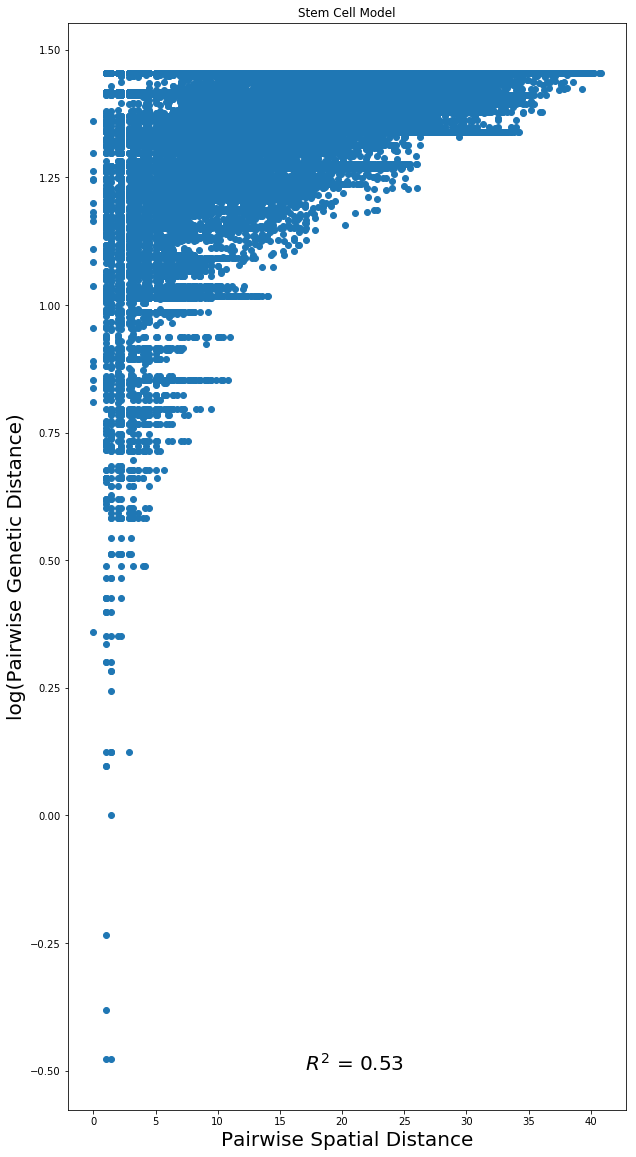

In [56]:
fig1,ax = plt.subplots(1,figsize=(10,20),facecolor='w')
genetic_vector_CSC_log = [math.log(y,10) for y in genetic_vector_CSC]
ax.scatter(spatial_vector_CSC,genetic_vector_CSC_log)
ax.set_xlabel('Pairwise Spatial Distance',size = 20)
ax.set_ylabel('log(Pairwise Genetic Distance)', size = 20)
ax.set_title('Stem Cell Model')

r1 =  np.corrcoef(spatial_vector_CSC,genetic_vector_CSC_log)[1,0]
ax.text(17,-0.5,'$R^2$ = %.2f'%r1,fontsize = 20)


from statsmodels.nonparametric.api import KernelReg

# xgrid = np.linspace(0,int(max(spatial_vector)))
# model = KernelReg(genetic_vector,spatial_vector,var_type = 'c',reg_type = 'll')
# reg_vals, x = model.fit(data_predict = xgrid)
# ax.plot(xgrid,reg_vals, "b-", linewidth=3.0,zorder = 12)

plt.savefig('figures/CSCsimultation_genetic_pair_log.png')
plt.show()

In [26]:
# from itertools import product
# def distance(p0,p1):
#     return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

# dfunc = np.vectorize(distance)

# genetic_vector = []
# spatial_vector = []
# leaf_heights = np.array([leaf.height for leaf in rtree_CC.leaves])
# leaf_locations = np.array([(leaf.locx, leaf.locy) for leaf in rtree_CC.leaves])
# # leaf_x = [leaf.locx for leaf in rtree_CC.leaves]
# # leaf_y = [leaf.locy for leaf in rtree_CC.leaves]
# # leaf_locations = np.array(zip(leaf_x,leaf_y))
# for node in rtree_CC.nodes:
#     if isinstance(node.children[0],bt.node):
#         left_child, right_child = node.children
#         left_heights = leaf_heights[left_child.leaves]
#         right_heights = leaf_heights[right_child.leaves]
#         # genetic_pairs = np.array(np.meshgrid(left_heights,right_heights)).T.reshape(-1,2)
#         genetic_pairs = np.array(list(product(left_heights, right_heights)))
#         genetic_distance = np.sum(genetic_pairs,axis = 1) - 2*node.height
#         genetic_vector.append(genetic_distance)
        
#         left_coords = leaf_locations[left_child.leaves]
#         right_coords = leaf_locations[right_child.leaves]
#         location_pairs = np.array(list(product(left_coords, right_coords)))
#         spatial_distance = distance(location_pairs[0][0],location_pairs[0][1])
#         spatial_vector.append(spatial_distance)
        
        

In [39]:
def distance_vectorize(tree):    
    distance_vector = []
    rank_vector = []
    color_vector = []
    edge_cells = []
    edge_distance = []
    for a in tree.leaves:
        if a.alive:
            distance = calc_distance(a.locx,a.locy,500,500)
            distance_vector.append(distance)
            rank_vector.append(a.rank)
            free_cells = adjacent_cell(lattice_CC,a.locx,a.locy)
            if len(free_cells) > 1:
                edge_cells.append(a)
    for a in tree.leaves:
        if a.alive:
            edist = 100000
            for e in edge_cells:
                edist_prop = calc_distance(a.locx,a.locy,e.locx,e.locy)
                if edist_prop < edist:
                    edist = edist_prop
            edge_distance.append(edist)
    return distance_vector, edge_distance, rank_vector

In [40]:
def pairwise_gen(tree,skip = 10):    
    spatial_vector = []
    genetic_vector = []

    for node in tree.nodes:
        nonleaf1 = isinstance(node.children[0],bt.node)
        if nonleaf1:
            for index1 in [x for x in node.children[0].leaves if x%skip == 0]:
                for index2 in node.children[1].leaves:
                    leaf1 = [x for x in tree.leaves if x.index == index1][0]
                    leaf2 = [x for x in tree.leaves if x.index == index2][0]
                    distance = calc_distance(leaf1.locx,leaf1.locy,leaf2.locx,leaf2.locy)
                    spatial_vector.append(distance)
                    genetic = (leaf1.height - node.height) + (leaf2.height - node.height)
                    genetic_vector.append(genetic)
    return spatial_vector,genetic_vector

In [51]:
### do this for multiple iterations of model
def simulation_LBI(num_iter,cancer_model = False,max_xgrid = 20):
    xgrid = np.linspace(0,max_xgrid)
    results = np.zeros((num_iter,len(xgrid)))
    for i in range(num_iter):
        alive = False
        while not alive:
            cells, alive_cells, lattice = cancer_sim(founder_cells = 1,max_cells = 1000,proliferationCSC = .5,proliferationCC = 1,CSC = cancer_model,pmax = 10,mutation = 0.1,mortality = 0.5)
            if len(alive_cells) > 0:
                alive = True
        full_tree = cells_to_tree(cells)
        ttree = calc_LBI(full_tree,tau = 0.5)
        rtree = rank_LBI(ttree)
        distance_vector, edge_distance, rank_vector = distance_vectorize(rtree)
        model = KernelReg(rank_vector,distance_vector,var_type = 'c',reg_type = 'll')
        reg_vals, x = model.fit(data_predict = xgrid)
        results[i] = reg_vals
        np.save("results.npy",results)
    return results
    


In [42]:
### do this for multiple iterations of model
def simulation_pairwise(num_iter,cancer_model = False,max_xgrid = 30,skip = 10):
    xgrid = np.linspace(0,max_xgrid)
    results = np.zeros((num_iter,len(xgrid)))
    for i in range(num_iter):
        alive = False
        while not alive:
            cells, alive_cells, lattice = cancer_sim(founder_cells = 1,max_cells = 1000,proliferationCSC = .5,proliferationCC = 1,CSC = cancer_model,pmax = 10,mutation = 0.1,mortality = 0.5)
            if len(alive_cells) > 0:
                alive = True
        full_tree = cells_to_tree(cells)
        ttree = calc_LBI(full_tree,tau = 0.5)
        rtree = rank_LBI(ttree)
        spatial_vector,genetic_vector = pairwise_gen(rtree,skip = skip)
        model = KernelReg(genetic_vector,spatial_vector,var_type = 'c',reg_type = 'll')
        reg_vals, x = model.fit(data_predict = xgrid)
        results[i] = reg_vals
        np.save("results.npy",results)
    return results
    


In [213]:
sim_lbi = simulation_LBI(100,cancer_model = False)

no cells alive
no cells alive
no cells alive
no cells alive


In [49]:
average = np.mean(sim_lbi,axis = 0)
lower_bound = np.percentile(sim_lbi, 5, axis = 0)
upper_bound = np.percentile(sim_lbi, 95, axis = 0)

NameError: name 'sim_lbi' is not defined

In [48]:
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w')
xgrid = np.linspace(0,20)
ax.plot(xgrid,average, "b-", linewidth=2.0,zorder = 12)
ax.plot(xgrid,lower_bound, "b--", linewidth=2,zorder = 13)
ax.plot(xgrid,upper_bound, "b--", linewidth=2.0,zorder = 12)
ax.fill_between(xgrid, lower_bound, upper_bound, facecolor='blue',zorder = 10,alpha = 0.4)
ax.set_xlabel('Distance from founding cell')
ax.set_ylabel('LBI Rank')
ax.set_title('Clonal Cell Model')
plt.savefig('figures/CC_LBIsim')
plt.show()


NameError: name 'average' is not defined

In [52]:
sim_lbi_CSC = simulation_LBI(100,cancer_model = True)

In [53]:
average_CSC = np.mean(sim_lbi_CSC,axis = 0)
lower_bound_CSC = np.percentile(sim_lbi_CSC, 5, axis = 0)
upper_bound_CSC = np.percentile(sim_lbi_CSC, 95, axis = 0)

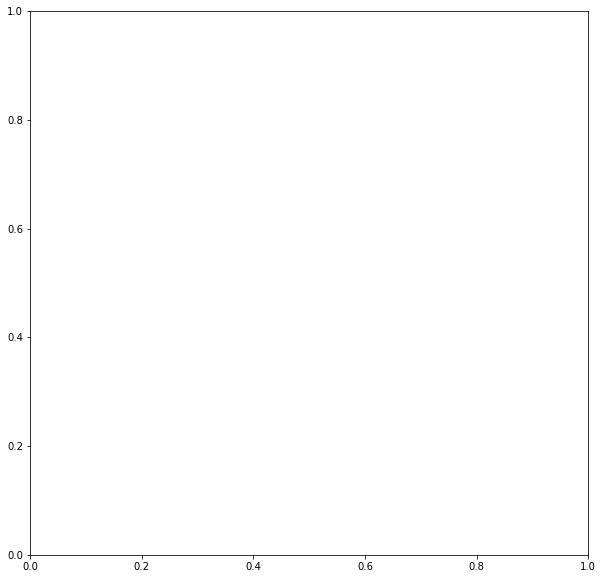

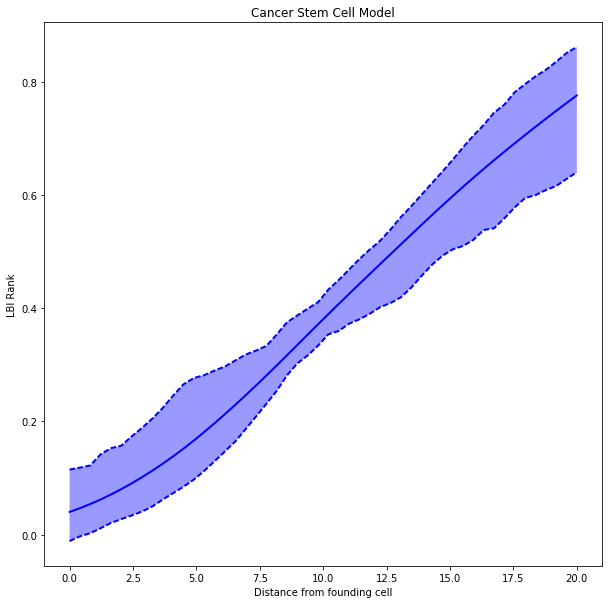

In [54]:
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w')
xgrid = np.linspace(0,20)
ax.plot(xgrid,average_CSC, "b-", linewidth=2.0,zorder = 12)
ax.plot(xgrid,lower_bound_CSC, "b--", linewidth=2,zorder = 13)
ax.plot(xgrid,upper_bound_CSC, "b--", linewidth=2.0,zorder = 12)
ax.fill_between(xgrid, lower_bound_CSC, upper_bound_CSC, facecolor='blue',zorder = 10,alpha = 0.4)
ax.set_xlabel('Distance from founding cell')
ax.set_ylabel('LBI Rank')
ax.set_title('Cancer Stem Cell Model')
plt.savefig('figures/CSC_LBIsim')
plt.show()

In [55]:
pair_sim_CC = simulation_pairwise(100,cancer_model = False, skip = 100)

no cells alive
no cells alive
no cells alive


In [56]:
average_pairCC = np.mean(pair_sim_CC,axis = 0)
lower_bound_pairCC = np.percentile(pair_sim_CC, 5, axis = 0)
upper_bound_pairCC = np.percentile(pair_sim_CC, 95, axis = 0)

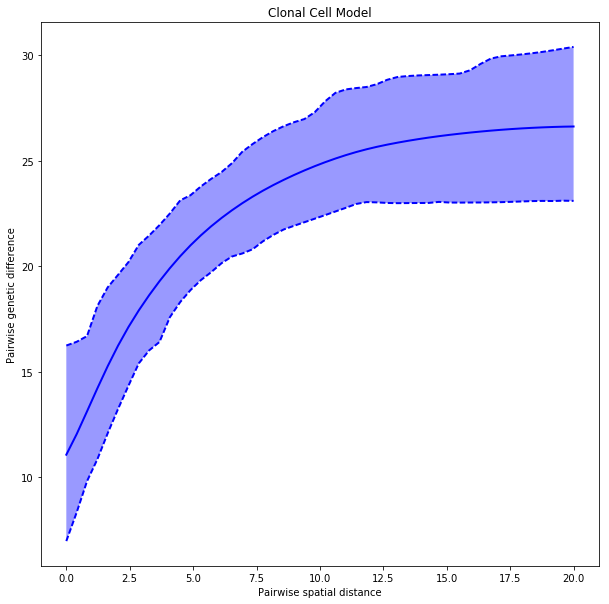

In [58]:
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w')
xgrid = np.linspace(0,20)
ax.plot(xgrid,average_pairCC, "b-", linewidth=2.0,zorder = 12)
ax.plot(xgrid,lower_bound_pairCC, "b--", linewidth=2,zorder = 13)
ax.plot(xgrid,upper_bound_pairCC, "b--", linewidth=2.0,zorder = 12)
ax.fill_between(xgrid, lower_bound_pairCC, upper_bound_pairCC, facecolor='blue',zorder = 10,alpha = 0.4)
ax.set_xlabel('Pairwise spatial distance')
ax.set_ylabel('Pairwise genetic difference')
ax.set_title('Clonal Cell Model')
plt.savefig('figures/CC_genetic_sim_iter')
plt.show()

In [59]:
pair_sim_CSC = simulation_pairwise(100,cancer_model = True, skip = 100)

KeyboardInterrupt: 

In [ ]:
average_pairCSC = np.mean(pair_sim_CSC,axis = 0)
lower_bound_pairCSC = np.percentile(pair_sim_CSC, 5, axis = 0)
upper_bound_pairCSC = np.percentile(pair_sim_CSC, 95, axis = 0)

In [ ]:
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w')
xgrid = np.linspace(0,20)
ax.plot(xgrid,average_pairCSC, "b-", linewidth=2.0,zorder = 12)
ax.plot(xgrid,lower_bound_pairCSC, "b--", linewidth=2,zorder = 13)
ax.plot(xgrid,upper_bound_pairCSC, "b--", linewidth=2.0,zorder = 12)
ax.fill_between(xgrid, lower_bound_pairCC, upper_bound_pairCC, facecolor='blue',zorder = 10,alpha = 0.4)
ax.set_xlabel('Pairwise spatial distance')
ax.set_ylabel('Pairwise genetic difference')
ax.set_title('Cancer Stem Cell Model')
plt.savefig('figures/CSC_genetic_sim_iter')
plt.show()